#### Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import sympy as sp

## Part 2

## Constructing Binomial Tree

#### Calculating u and d using the Expected value and Variance equation

In [6]:
def calculate_u_d(steps):
    # Define symbols
    r_u, r_d = sp.symbols('r_u r_d')
    
    # Monthly expected return and variance
    monthly_return = 0.006
    monthly_variance = 0.047**2
    
    # Adjust return and variance based on steps
    adjusted_return = monthly_return * (3 / steps)
    adjusted_variance = monthly_variance * (3 / steps)
    
    # Define the two equations
    expected_return_eq = 0.56 * r_u + 0.44 * r_d - adjusted_return  # Expected return equation
    variance_eq = 0.56 * (r_u - adjusted_return)**2 + 0.44 * (r_d - adjusted_return)**2 - adjusted_variance  # Variance equation
    
    # Solve the system of equations
    solution_discrete = sp.solve([expected_return_eq, variance_eq], (r_u, r_d))
    
    # Calculate u and d from the returns
    u_1 = np.round(float(1 + solution_discrete[0][0]), 5)  # First set (u and d)
    d_1 = np.round(float(1 + solution_discrete[0][1]), 5)
    
    return u_1, d_1

u_1, d_1 = calculate_u_d(3)
print("u:", u_1)
print("d:", d_1)

u: 1.04766
d: 0.95298


In [7]:
r_u, r_d = sp.symbols('r_u r_d')

# Given variance (V) based on the provided standard deviation
variance = 0.047**2

# Define the two equations
expected_return_eq = 0.56 * r_u + 0.44 * r_d - 0.006  # Expected return equation
variance_eq = 0.56 * (r_u - 0.006)**2 + 0.44 * (r_d - 0.006)**2 - variance  # Variance equation

# Solve the system of equations
solution_discrete = sp.solve([expected_return_eq, variance_eq], (r_u, r_d))

solution_discrete
u = float(1 + solution_discrete[0][0])
d = float(1 + solution_discrete[0][1])

print(u)
print(d)

1.0476610472401122
0.95297684896713


#### Calculation Risk neutral probabilities

In [10]:
r = 0.04
u = u_1 
d = d_1

# Using the formulas provided for risk-neutral probabilities
R = r/12 # Risk-free rate per month

# Calculate q_u and q_d
q_u = np.round(((1 + R) - d) / (u - d),4)
q_d = np.round((u - (1 + R)) / (u - d),4)

q_u, q_d


(0.5318, 0.4682)

#### Part a)

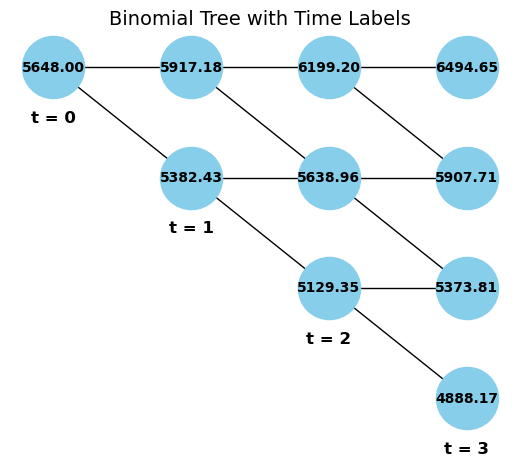

Stock Price Binomial Tree:
[[5648.         5917.18368    6199.19665419 6494.65036673]
 [   0.         5382.43104    5638.95770337 5907.71042751]
 [   0.            0.         5129.3491325  5373.81391215]
 [   0.            0.            0.         4888.16713629]]


In [12]:
# Visualization function
def visualize_binomial_tree(stock_tree, time_labels):
    G = nx.DiGraph()
    
    # Create edges with labels
    for i in range(stock_tree.shape[1]):
        for j in range(i + 1):
            G.add_node(f'{i},{j}', label=f'{stock_tree[j, i]:.2f}')
            if i < stock_tree.shape[1] - 1:
                G.add_edge(f'{i},{j}', f'{i+1},{j}', weight='U')  # Up move
                G.add_edge(f'{i},{j}', f'{i+1},{j+1}', weight='D')  # Down move
    
    # Create positions for the nodes
    pos = {}
    for i in range(stock_tree.shape[1]):
        for j in range(i + 1):
            pos[f'{i},{j}'] = (i, -j)  # Layout the nodes in a triangular pattern
    
    labels = nx.get_node_attributes(G, 'label')
    
    # Draw the graph
    plt.figure(figsize=(5, 4))
    nx.draw(G, pos, labels=labels, with_labels=True, node_size=2000, node_color='skyblue', font_size=10, font_weight='bold', arrows=False)
    
    # Add time labels
    for i in range(stock_tree.shape[1]):
        plt.text(i, -i - 0.5, f't = {time_labels[i]}', horizontalalignment='center', fontsize=12, fontweight='bold')
    
    plt.title("Binomial Tree with Time Labels", size=14)
    plt.show()

# Function to generate binomial tree using the calculated u and d values
def generate_binomial_tree(S0, u, d, N, output = "graph"):
    
    # Initialize the binomial tree
    stock_tree = np.zeros((N + 1, N + 1))
    
    # Fill the tree with stock prices
    for i in range(N + 1):
        for j in range(i + 1):
            stock_tree[j, i] = S0 * (u ** (i - j)) * (d ** j)
    
    # Output options
    if output == "graph" or output == "both":
        visualize_binomial_tree(stock_tree, [i for i in range(N + 1)])
    
    if output == "tree" or output == "both":
        print("Stock Price Binomial Tree:")
        print(stock_tree)

# Example input values
S0 = 5648  # Initial S&P-500 index level
u = u_1 # Calculated upward factor
d = d_1  # Calculated downward factor
N = 3  # Number of time steps (3 months)

# Generate and visualize the binomial tree
generate_binomial_tree(S0, u, d, N, output="both")


### Part b)

#### 3 month Call Option Price

In [15]:
# Parameters
S0 = 5648 
K = 5600  
r = 0.04  
N = 3  # Number of steps
u, d = calculate_u_d(3)

R = (r*0.25)/N # Monthly Rate

# Step 1: Initialize the stock price tree
stock_tree = np.zeros((N + 1, N + 1))

# Step 2: Fill the stock price tree
for i in range(N + 1):
    for j in range(i + 1):
        stock_tree[j, i] = S0 * (u ** (i - j)) * (d ** j)

# Step 3: Initialize the option price tree
option_tree = np.zeros((N + 1, N + 1))

# Step 4: Calculate the option payoff at maturity (t = N)
for j in range(N + 1):
    option_tree[j, N] = max(stock_tree[j, N] - K, 0)  # Payoff at maturity

# Step 5: Backward induction to calculate option price at earlier nodes
for i in range(N - 1, -1, -1):
    for j in range(i + 1):
        option_tree[j, i] = (q_u * option_tree[j, i + 1] + q_d * option_tree[j + 1, i + 1]) / (1 + R)

# The option price at the root of the tree (at t = 0)
option_price_at_t0 = option_tree[0, 0]
print("Price of 3-month European Call Option is", np.round(option_price_at_t0,4))


Price of 3-month European Call Option is 254.2375


In [16]:
option_tree

array([[254.23754153, 403.55520318, 617.78580118, 894.65036673],
       [  0.        ,  86.44669574, 163.09674952, 307.71042751],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ]])

In [17]:
stock_tree

array([[5648.        , 5917.18368   , 6199.19665419, 6494.65036673],
       [   0.        , 5382.43104   , 5638.95770337, 5907.71042751],
       [   0.        ,    0.        , 5129.3491325 , 5373.81391215],
       [   0.        ,    0.        ,    0.        , 4888.16713629]])

### Part c)

In [19]:
from scipy.stats import norm

def black_scholes(S0, K, r, T, sigma, option_type = 'Call'):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == "Call":
        option_price = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == "Put":
        option_price = K * np.exp(-r * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
    else:
        raise ValueError("Invalid option type. Please input 'Call' or 'Put'.")
    
    return option_price

# Parameters
S0 = 5648
K = 5600 
T = 3 / 12 
r = 0.04 
sigma_monthly = 0.047
sigma_annual = sigma_monthly * np.sqrt(12)

# Calculate the Black-Scholes price
bs_call_price = black_scholes(S0, K, r, T, sigma_annual,'Call')
print(f"The Black-Scholes price of the European call option is", np.round(bs_call_price,4))


The Black-Scholes price of the European call option is 238.2395


In [20]:
print("Price of CE using Binomial Model:", np.round(option_price_at_t0,3))
print("Price of CE using BSM Model:", np.round(bs_call_price,3))

Price of CE using Binomial Model: 254.238
Price of CE using BSM Model: 238.24


### Part d)

In [22]:
def price_european_call_binomial(S0, K, r, u, d, N, q_u=None, q_d=None):
   
    #R = r * delta_t 
    R = (r*0.25)/N
    if q_u is None:  
        q_u = (1 + R - d) / (u - d)
    if q_d is None: 
        q_d = 1 - q_u

    # Initialize stock price tree
    stock_tree = np.zeros((N + 1, N + 1))

    # Fill the stock price tree
    for i in range(N + 1):
        for j in range(i + 1):
            stock_tree[j, i] = S0 * (u ** (i - j)) * (d ** j)

    # Initialize option price tree
    option_tree = np.zeros((N + 1, N + 1))

    # Calculate option payoff at maturity (t = N)
    for j in range(N + 1):
        option_tree[j, N] = max(stock_tree[j, N] - K, 0)  # Payoff at maturity

    # Backward induction to calculate option price at earlier nodes
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            option_tree[j, i] = (q_u * option_tree[j, i + 1] + q_d * option_tree[j + 1, i + 1]) / (1 + R)

    # Return the option price at the root of the tree (at t = 0), along with stock_tree and option_tree
    option_price_at_t0 = option_tree[0, 0]
    return stock_tree, option_tree, option_price_at_t0


In [23]:
# Parameters
S0 = 5648 
K = 5600  
r = 0.04  
N = 3  # Number of steps
u, d = calculate_u_d(3)
stock_tree, option_tree, option_price_at_t0 = price_european_call_binomial(S0, K, r, u, d, N, q_u=None, q_d=None)
np.round(option_price_at_t0,3)

254.263

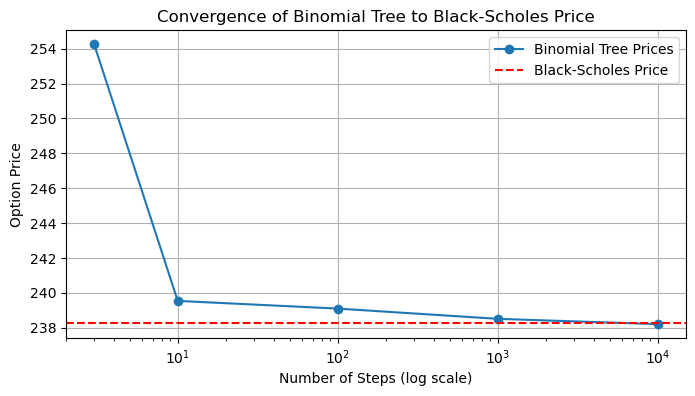

In [36]:
# Given parameters
S0 = 5648  # Initial stock price
K = 5600   # Strike price
r = 0.04   # Annual risk-free rate
T = 3 / 12  # 3 months = 0.25 years
sigma = 0.047 * np.sqrt(12)  # Annual volatility

# Calculate Black-Scholes option price
bs_option_price = black_scholes(S0, K, r, T, sigma, 'Call')

# Step sizes and binomial tree calculations
steps = [3, 10, 100, 1000, 10000]  # Number of steps to try
binomial_prices_call = []
for N in steps:
    #delta_t = T / N  # Adjust delta_t for each N steps
    u, d = calculate_u_d(N)
    stock_tree, option_tree, price = price_european_call_binomial(S0, K, r, u, d, N)
    binomial_prices_call.append(price)

# Plot the results
plt.figure(figsize=(8, 4))
plt.plot(steps, binomial_prices_call, label="Binomial Tree Prices", marker='o')
plt.axhline(y=bs_option_price, color='r', linestyle='--', label="Black-Scholes Price")
plt.xscale('log')  # Log scale for better visualization of convergence
plt.xlabel('Number of Steps (log scale)')
plt.ylabel('Option Price')
plt.title('Convergence of Binomial Tree to Black-Scholes Price')
plt.legend()
plt.grid(True)
plt.show()

### Part e)

In [37]:
option_tree_10000 = pd.DataFrame(option_tree)

In [38]:
option_tree_10000.columns = ['Sim_'+str(i) for i in range(0,len(option_tree_10000))]

In [50]:
# Given parameters
N = 10000
S0 = 5648  
K = 5600  
r = 0.04  
T = 3 / 12  
sigma = 0.047*np.sqrt(12)  
u, d = calculate_u_d(N)
q_u = 0.56
q_d = 1 - q_u
stock_tree, option_tree, price = price_european_call_binomial(S0, K, r, u, d, N, q_u, q_d)

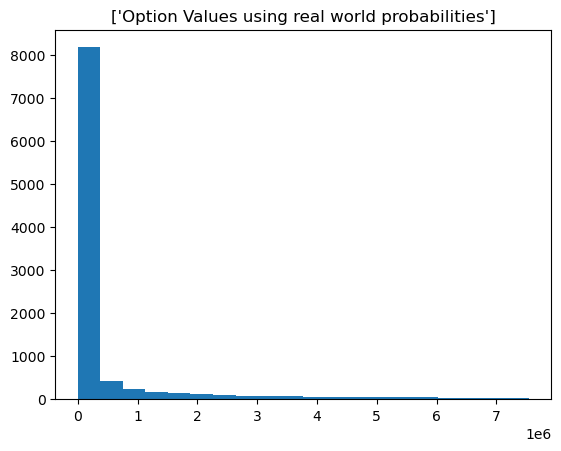

In [51]:
option_tree_10000_2 = pd.DataFrame(option_tree)
option_tree_10000_2.columns = ['Sim_'+str(i) for i in range(0,len(option_tree_10000))]
plt.hist(list(np.round(option_tree_10000_2['Sim_10000'],3)), bins = 20)
plt.title(['Option Values using real world probabilities'])
plt.show()

### Part f)

In [52]:
def price_european_put_binomial(S0, K, r, u, d, N, q_u=None, q_d=None):
    # Adjust the rate R as in the call option function
    R = (r * 0.25) / N  # Discrete rate per step, adjusted for N steps
    if q_u is None:  # Risk-neutral probability for upward move
        q_u = np.round((1 + R - d) / (u - d),4)
    if q_d is None:  # Risk-neutral probability for downward move
        q_d = 1 - q_u

    # Initialize stock price tree
    stock_tree = np.zeros((N + 1, N + 1))

    # Fill the stock price tree
    for i in range(N + 1):
        for j in range(i + 1):
            stock_tree[j, i] = S0 * (u ** (i - j)) * (d ** j)

    # Initialize option price tree
    option_tree = np.zeros((N + 1, N + 1))

    # Calculate put option payoff at maturity (t = N)
    for j in range(N + 1):
        option_tree[j, N] = max(K - stock_tree[j, N], 0)  # Put option payoff at maturity

    # Backward induction to calculate option price at earlier nodes
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            option_tree[j, i] = (q_u * option_tree[j, i + 1] + q_d * option_tree[j + 1, i + 1]) / (1 + R)

    # Return the option price at the root of the tree (at t = 0), along with stock_tree and option_tree
    option_price_at_t0 = option_tree[0, 0]
    return stock_tree, option_tree, option_price_at_t0

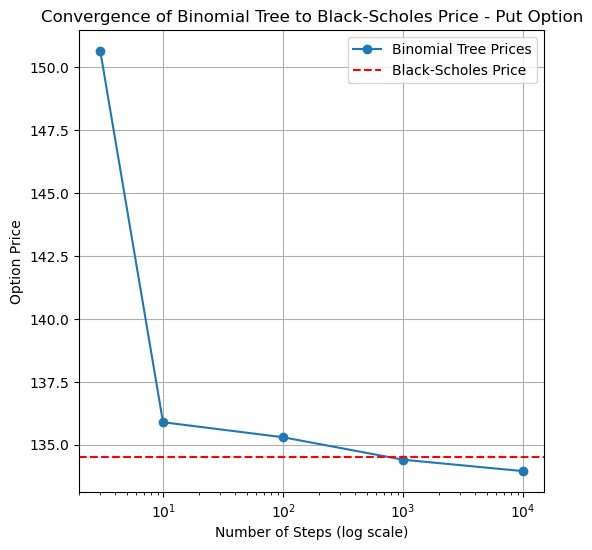

In [53]:
# Example usage
# Given parameters
S0 = 5648  # Initial stock price
K = 5600   # Strike price
r = 0.04   # Annual risk-free rate
T = 3 / 12  # 3 months = 0.25 years
sigma = 0.047 * np.sqrt(12)  # Annual volatility

steps =  [3, 10, 100, 1000, 10000]  # Number of steps to try

# Calculate Black-Scholes option price
bs_option_price = black_scholes(S0, K, r, T, sigma, "Put")

# Calculate binomial tree prices for different step counts
binomial_prices_put = []
for N in steps:
    u, d = calculate_u_d(N)
    stock_tree, option_tree, price = price_european_put_binomial(S0, K, r, u, d, N)
    binomial_prices_put.append(price)

# Plot the results
plt.figure(figsize=(6, 6))
plt.plot(steps, binomial_prices_put, label="Binomial Tree Prices", marker='o')
plt.axhline(y=bs_option_price, color='r', linestyle='--', label="Black-Scholes Price")
plt.xscale('log')  # Log scale for better visualization of convergence
plt.xlabel('Number of Steps (log scale)')
plt.ylabel('Option Price')
plt.title('Convergence of Binomial Tree to Black-Scholes Price - Put Option')
plt.legend()
plt.grid(True)
plt.show()

In [54]:
print(binomial_prices_put)
print(binomial_prices_call)

[150.65118788935806, 135.89183498116356, 135.29432608234103, 134.40123718379226, 133.94733501803128]
[254.2626716461956, 239.53470951443222, 239.09325659762106, 238.50551006204492, 238.20229034953272]


In [55]:
import numpy as np

# Given values
S0 = 5648  # Current stock price
K = 5600   # Strike price
r = 0.04   # Risk-free interest rate
T = 3 / 12 # Time to maturity (3 months = 0.25 years)
n = 12     # Compounding frequency (monthly compounding)

# Call and put prices (assumed to be American options, though put-call parity applies to European options)
C = np.round(binomial_prices_call[0],2) # Call option price
P = np.round(binomial_prices_put[0],2)# Put option price

# Put-Call Parity: Left-hand side (C - P)
put_call_parity_lhs = np.round(C - P,2)

# Right-hand side (S0 - K * (1 + r/n)^(-nT)) using discrete compounding
put_call_parity_rhs = np.round(S0 - K * (1 + r / n) ** (-n * T),2)

# Print the results
print(f"Left-hand side (C - P): {put_call_parity_lhs}")
print(f"Right-hand side (S0 - K * (1 + r/n)^(-nT)): {put_call_parity_rhs}")

# Check if they are approximately equal
if np.isclose(put_call_parity_lhs, put_call_parity_rhs):
    print("Put-Call Parity holds")
else:
    print("Put-Call Parity does not hold")


Left-hand side (C - P): 103.61
Right-hand side (S0 - K * (1 + r/n)^(-nT)): 103.63
Put-Call Parity does not hold


### Part g)

#### American Call & Put Option

In [56]:
def price_american_put_binomial(S0, K, r, u, d, N, q_u=None, q_d=None):
    # Risk-neutral probabilities using discrete compounding
    R = (r * 0.25) / N  # Discrete rate per step
    if q_u is None:  # Risk-neutral probability for upward move
        q_u = (1 + R - d) / (u - d)  
    if q_d is None:  # Risk-neutral probability for downward move
        q_d = 1 - q_u

    # Initialize stock price tree
    stock_tree = np.zeros((N + 1, N + 1))

    # Fill the stock price tree
    for i in range(N + 1):
        for j in range(i + 1):
            stock_tree[j, i] = S0 * (u ** (i - j)) * (d ** j)

    # Initialize option price tree
    option_tree = np.zeros((N + 1, N + 1))

    # Calculate put option payoff at maturity (t = N)
    for j in range(N + 1):
        option_tree[j, N] = max(K - stock_tree[j, N], 0)  # Put option payoff at maturity

    # Backward induction to calculate option price at earlier nodes, allowing for early exercise
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            # Expected value from holding the option (as in the European case)
            hold_value = (q_u * option_tree[j, i + 1] + q_d * option_tree[j + 1, i + 1]) / (1 + R)
            # Payoff from early exercise
            exercise_value = max(K - stock_tree[j, i], 0)
            # Take the maximum of holding the option vs early exercise
            option_tree[j, i] = max(hold_value, exercise_value)

    # Return the option price at the root of the tree (at t = 0), along with stock_tree and option_tree
    option_price_at_t0 = option_tree[0, 0]
    return stock_tree, option_tree, option_price_at_t0

def price_american_call_binomial(S0, K, r, u, d, N, q_u=None, q_d=None):
    # Risk-neutral probabilities using discrete compounding
    R = (r * 0.25) / N  # Discrete rate per step
    if q_u is None:  # Risk-neutral probability for upward move
        q_u = (1 + R - d) / (u - d)  
    if q_d is None:  # Risk-neutral probability for downward move
        q_d = 1 - q_u

    # Initialize stock price tree
    stock_tree = np.zeros((N + 1, N + 1))

    # Fill the stock price tree
    for i in range(N + 1):
        for j in range(i + 1):
            stock_tree[j, i] = S0 * (u ** (i - j)) * (d ** j)

    # Initialize option price tree
    option_tree = np.zeros((N + 1, N + 1))

    # Calculate call option payoff at maturity (t = N)
    for j in range(N + 1):
        option_tree[j, N] = max(stock_tree[j, N] - K, 0)  # Call option payoff at maturity

    # Backward induction to calculate option price at earlier nodes, allowing for early exercise
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            # Expected value from holding the option (as in the European case)
            hold_value = (q_u * option_tree[j, i + 1] + q_d * option_tree[j + 1, i + 1]) / (1 + R)
            # Payoff from early exercise
            exercise_value = max(stock_tree[j, i] - K, 0)
            # Take the maximum of holding the option vs early exercise
            option_tree[j, i] = max(hold_value, exercise_value)

    # Return the option price at the root of the tree (at t = 0), along with stock_tree and option_tree
    option_price_at_t0 = option_tree[0, 0]
    return stock_tree, option_tree, option_price_at_t0
    

In [57]:
S0 = 5648  
K = 5600  
r = 0.04  
N = 3  
u, d = calculate_u_d(N)

# Correctly calling the American call and put option functions
stock_tree, option_tree, CA_price = price_american_call_binomial(S0, K, r, u, d, N, q_u=None, q_d=None)
stock_tree, option_tree, CE_price = price_european_call_binomial(S0, K, r, u, d, N, q_u=None, q_d=None)
stock_tree, option_tree, PE_price = price_european_put_binomial(S0, K, r, u, d, N, q_u=None, q_d=None)
stock_tree, option_tree, PA_price = price_american_put_binomial(S0, K, r, u, d, N, q_u=None, q_d=None)

print("American Call Price:", CA_price)
print("European Call Price:", CE_price)
print("")
print("American Put Price:", PA_price)
print("European Put Price:", PE_price)

American Call Price: 254.2626716461956
European Call Price: 254.2626716461956

American Put Price: 154.68477758225322
European Put Price: 150.65118788935806
